<a href="https://colab.research.google.com/github/Rakeshboin/ev-charging-station/blob/main/codee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor

In [2]:
data1=pd.read_csv("energy_dataset.csv")
data1.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


/tmp/ipython-input-1821487972.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data1['time'] = pd.to_datetime(data1['time'])
/tmp/ipython-input-1821487972.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Type of Generation', y='Generation Output (MW)', data=data_long, palette=palette)


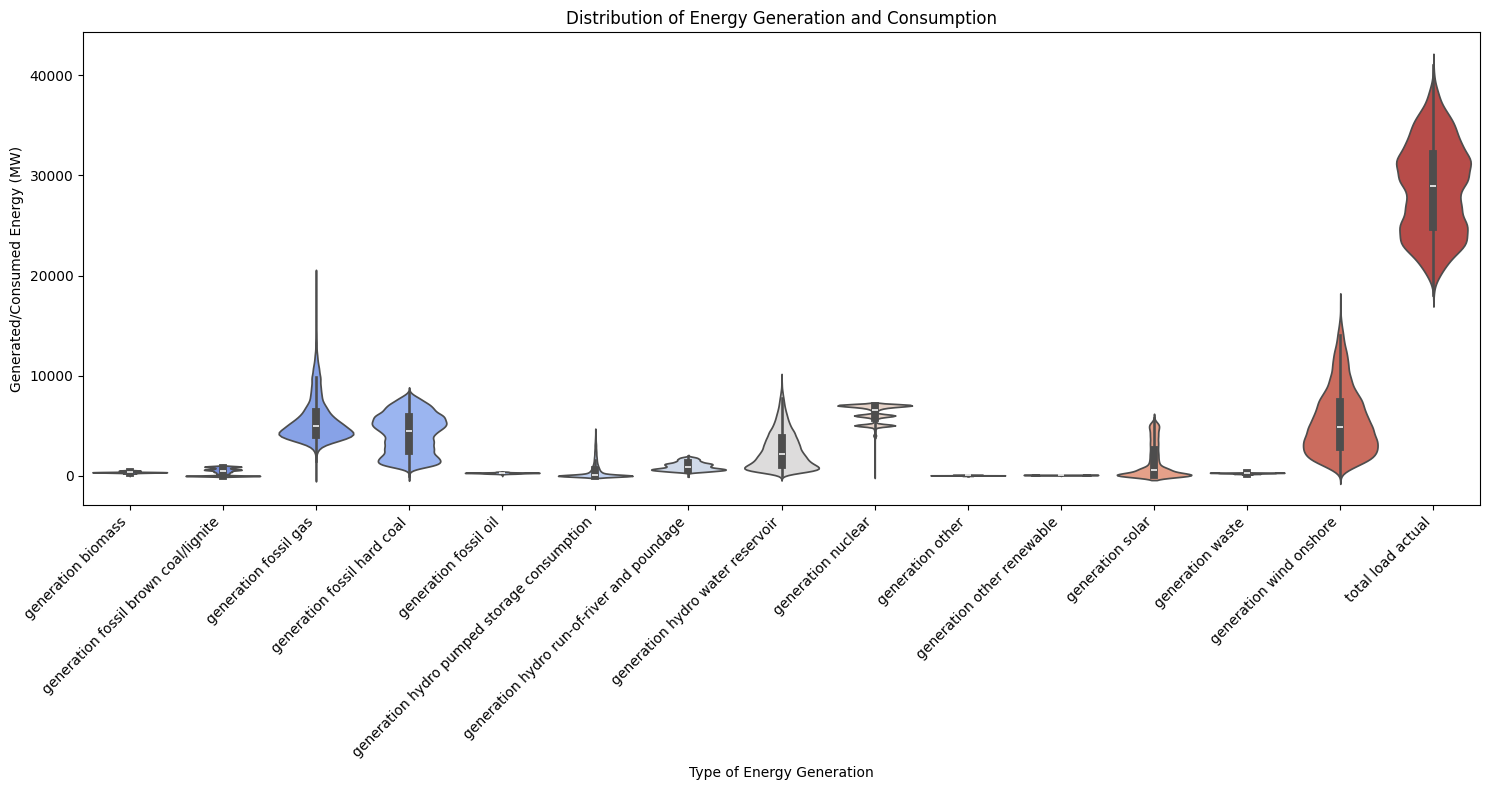

In [3]:
# Convert the 'time' column to datetime
data1['time'] = pd.to_datetime(data1['time'])

# Define the columns we want to plot
columns_to_plot = [
    'generation biomass',
    'generation fossil brown coal/lignite',
    'generation fossil gas',
    'generation fossil hard coal',
    'generation fossil oil',
    'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage',
    'generation hydro water reservoir',
    'generation nuclear',
    'generation other',
    'generation other renewable',
    'generation solar',
    'generation waste',
    'generation wind onshore',
    'total load actual'
]

# Filter the dataframe to only include the desired columns
data_to_plot = data1[columns_to_plot]

# Melt the data so that we have one column for variable names and one for values
data_long = pd.melt(data_to_plot, var_name='Type of Generation', value_name='Generation Output (MW)')

# Set a custom color palette
palette = sns.color_palette("coolwarm", len(columns_to_plot))

# Create the violin plot
plt.figure(figsize=(15, 8))
sns.violinplot(x='Type of Generation', y='Generation Output (MW)', data=data_long, palette=palette)

# Improve the aesthetics
plt.xticks(rotation=45, ha='right')  # Rotate the x labels for better readability
plt.title('Distribution of Energy Generation and Consumption')
plt.xlabel('Type of Energy Generation')
plt.ylabel('Generated/Consumed Energy (MW)')

# Show the plot
plt.tight_layout()  # This adjusts subplot params for the figure to fit into the display area
plt.show()

In [4]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [5]:
data1.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,...,35045.000000,35046.0,35046.000000,35064.000000,0.0,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,...,269.452133,0.0,5464.479769,1439.066735,NaN,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,...,50.195536,0.0,3213.691587,1677.703355,NaN,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,...,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,...,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,...,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,...,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,...,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


As we have a lot of data columns, so we will take only the relevant columns required for our model. Keep in mind 'price' is an important column, but we also require 'Appliances' data that can be used for forecasting model. As we don't have 'Appliances' data so we will not consider 'Price' column data for our model.

In [6]:
energy_df=data1.copy(deep=True)
energy_df = energy_df.drop(columns=['forecast solar day ahead','forecast wind offshore eday ahead','forecast wind onshore day ahead','total load forecast','price day ahead','generation hydro pumped storage aggregated','price actual'])
energy_df.isna().sum()

,0
time,0
generation biomass,19
generation fossil brown coal/lignite,18
generation fossil coal-derived gas,18
generation fossil gas,18
generation fossil hard coal,18
generation fossil oil,19
generation fossil oil shale,18
generation fossil peat,18
generation geothermal,18


In [7]:
#Changing the type of 'time' from string to date-time
energy_df['time']=pd.to_datetime(energy_df['time'],utc=True)
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 22 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   time                                         35064 non-null  datetime64[ns, UTC]
 1   generation biomass                           35045 non-null  float64            
 2   generation fossil brown coal/lignite         35046 non-null  float64            
 3   generation fossil coal-derived gas           35046 non-null  float64            
 4   generation fossil gas                        35046 non-null  float64            
 5   generation fossil hard coal                  35046 non-null  float64            
 6   generation fossil oil                        35045 non-null  float64            
 7   generation fossil oil shale                  35046 non-null  float64            
 8   generation fossil peat    

As we can see, 'energy_df' dataframe has no duplicate values. Nevertheless, it has some NaNs and thus, we have to investigate further. Since this is a time-series forecasting task, we cannot simply drop the rows with the missing values and it would be a better idea to fill the missing values using interpolation.

In [8]:
print('There are {} missing values or NaNs in energy_df.'
      .format(energy_df.isnull().values.sum()))
temp_energy = energy_df.duplicated(keep='first').sum()

print('There are {} duplicate rows in energy_df based on all columns.'
      .format(temp_energy))
energy_df.isnull().sum(axis=0)

There are 401 missing values or NaNs in energy_df.
There are 0 duplicate rows in energy_df based on all columns.


,0
time,0
generation biomass,19
generation fossil brown coal/lignite,18
generation fossil coal-derived gas,18
generation fossil gas,18
generation fossil hard coal,18
generation fossil oil,19
generation fossil oil shale,18
generation fossil peat,18
generation geothermal,18


Most null values can be found in the 'total load actual' column which represents the energy consumption. Therefore, it is a good idea to visualize it and see what we can do. The similar numbers in null values in the columns which have to do with the type of energy generation probably indicate that they will also appear in the same rows. Let us first define a normal distribution to see the irregualrities.

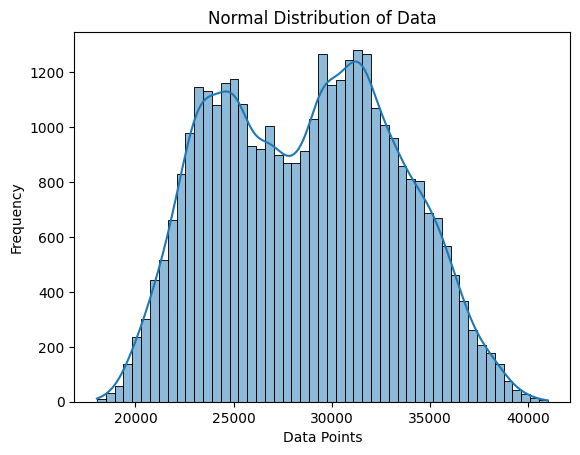

In [9]:
# Plotting the distribution
sns.histplot(energy_df['total load actual'], kde=True)  # 'kde=True' adds the Kernel Density Estimate to smooth the histogram
plt.title('Normal Distribution of Data')
plt.xlabel('Data Points')
plt.ylabel('Frequency')
plt.show()


Now lets see using a line plot.

In [10]:
def plot_series(df=None, column=None, series=pd.Series([]),
                label=None, ylabel=None, title=None, start=0, end=None):
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

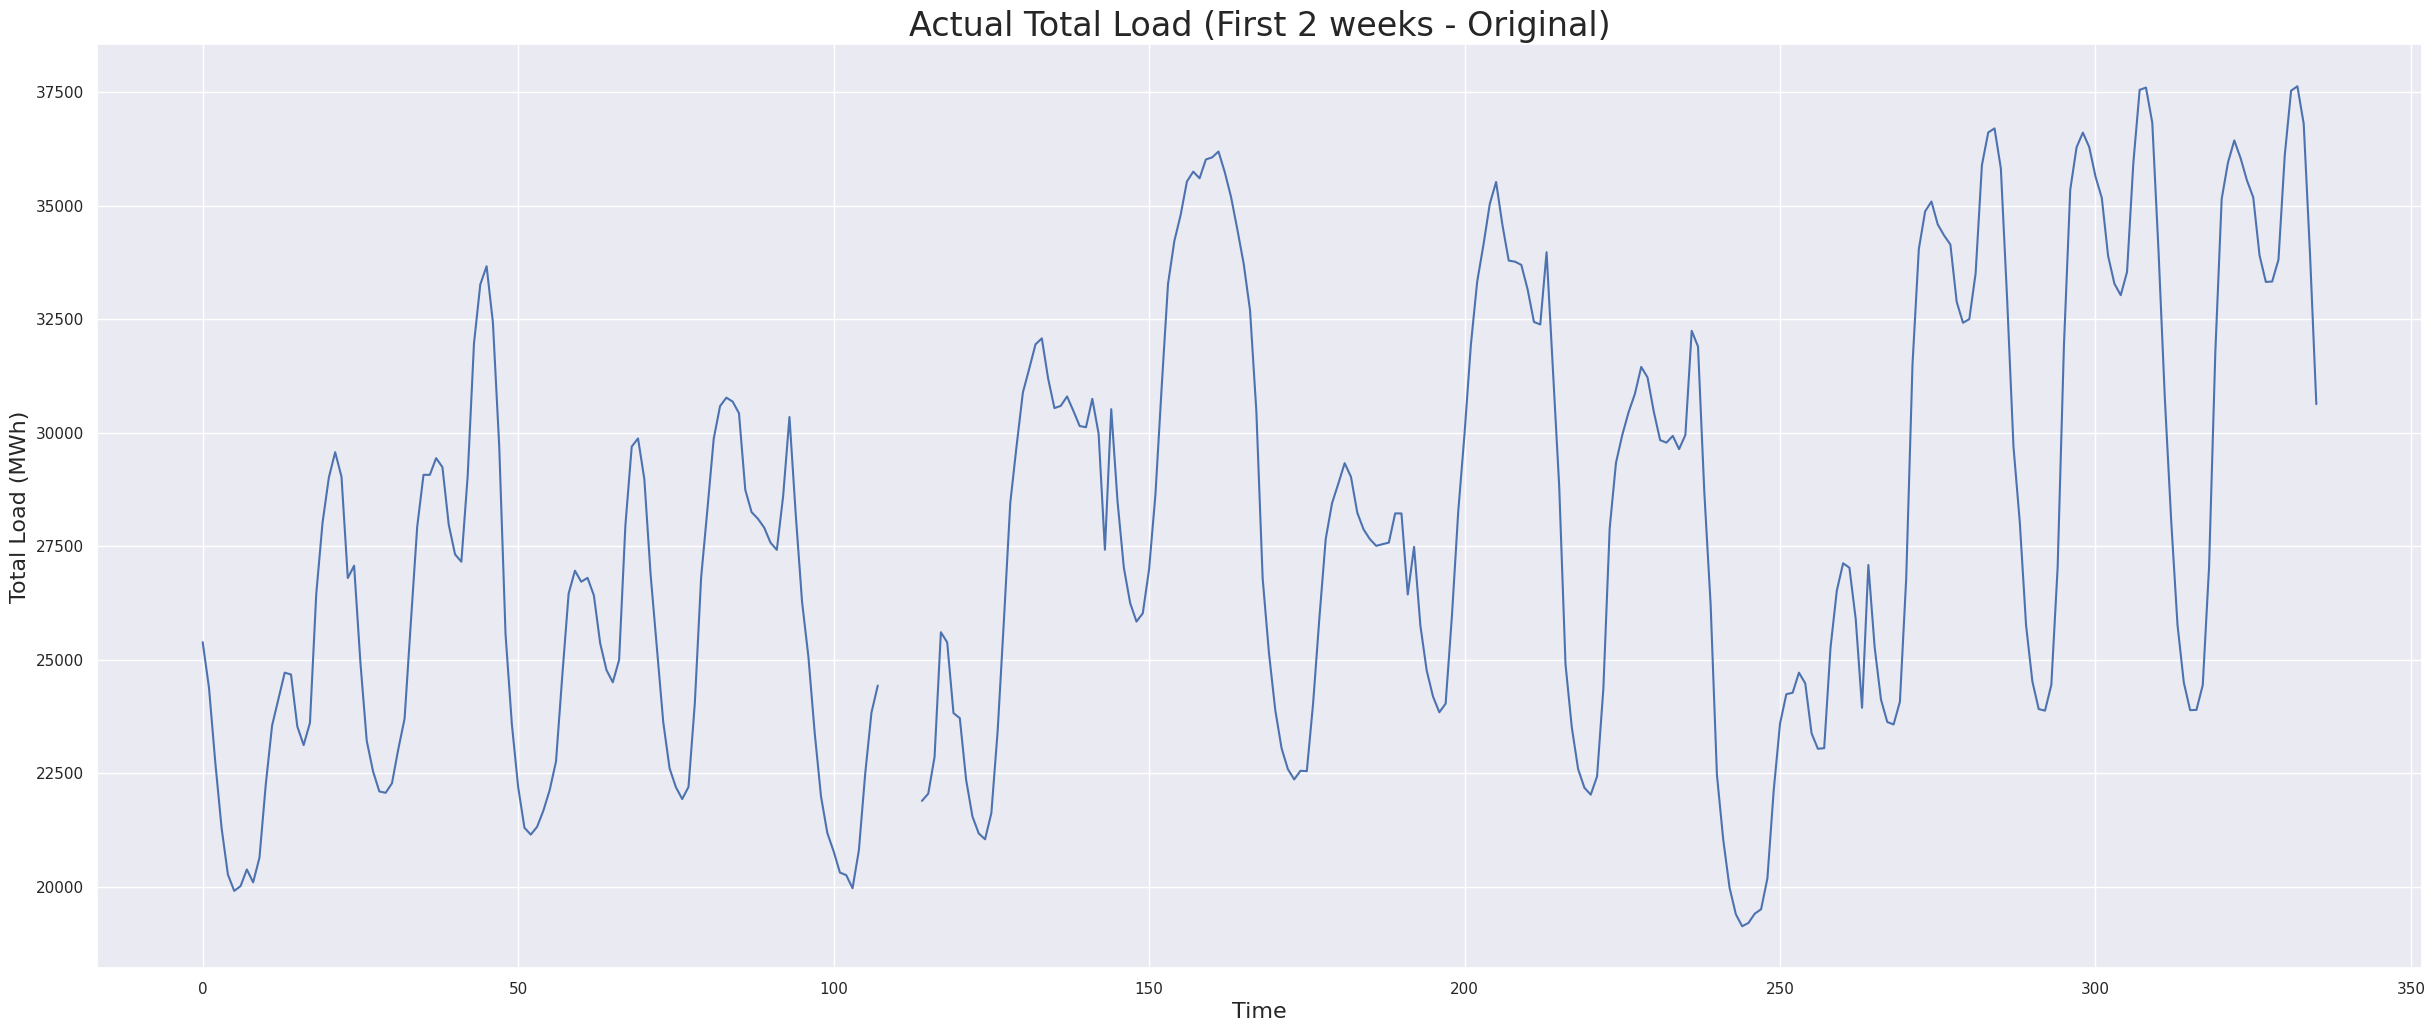

In [11]:
# Zoom into the plot of the hourly (actual) total load

ax = plot_series(df=energy_df, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Original)', end=24*7*2)
plt.show()

After zooming into the first 2 weeks of the 'total load actual' column, we can already see that there are null values for a few hours. However, the number of the missing values and the behavior of the series indicate that an interpolation would fill the NaNs quite well. Let us further investigate if the null values coincide across the different columns. Let us display the last five rows.

In [12]:
# Display the rows with null values
energy_df[energy_df.isnull().any(axis=1)].tail()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,total load actual
16612,2016-11-23 03:00:00+00:00,NaN,900.0,0.0,4838.0,4547.0,269.0,0.0,0.0,0.0,...,435.0,0.0,5040.0,60.0,85.0,15.0,227.0,0.0,4598.0,23112.0
25164,2017-11-14 11:00:00+00:00,0.0,0.0,0.0,10064.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
25171,2017-11-14 18:00:00+00:00,0.0,0.0,0.0,12336.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
30185,2018-06-11 16:00:00+00:00,331.0,506.0,0.0,7538.0,5360.0,300.0,0.0,0.0,0.0,...,4258.0,0.0,5856.0,52.0,96.0,170.0,269.0,0.0,9165.0,NaN
30896,2018-07-11 07:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


If we manually searched through all of them, we would confirm that the null values in the columns which have to do with the type of energy generation mostly coincide. The null values in 'actual total load' also coincide with the aforementioned columns, but also appear in other rows as well. In order to handle the null values in df_energy, we will use a linear interpolation with a forward direction. Perhaps other kinds of interpolation would be better; nevertheless, we prefer to use the simplest model possible. Only a small part of our input data will be noisy and it will not affect performance noticeably.

In [13]:
energy_df.replace(0, np.nan, inplace=True)
# Fill null values using interpolation
energy_df.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)
# Display the number of non-zero values in each column

print('Non-zero values in each column:\n', energy_df.astype(bool).sum(axis=0), sep='\n')

Non-zero values in each column:

time                                           35064
generation biomass                             35064
generation fossil brown coal/lignite           35064
generation fossil coal-derived gas             35064
generation fossil gas                          35064
generation fossil hard coal                    35064
generation fossil oil                          35064
generation fossil oil shale                    35064
generation fossil peat                         35064
generation geothermal                          35064
generation hydro pumped storage consumption    35064
generation hydro run-of-river and poundage     35064
generation hydro water reservoir               35064
generation marine                              35064
generation nuclear                             35064
generation other                               35064
generation other renewable                     35064
generation solar                               35064
generation wa

As we can see the count of values of all columns is similar, so now lets see through the line plot again

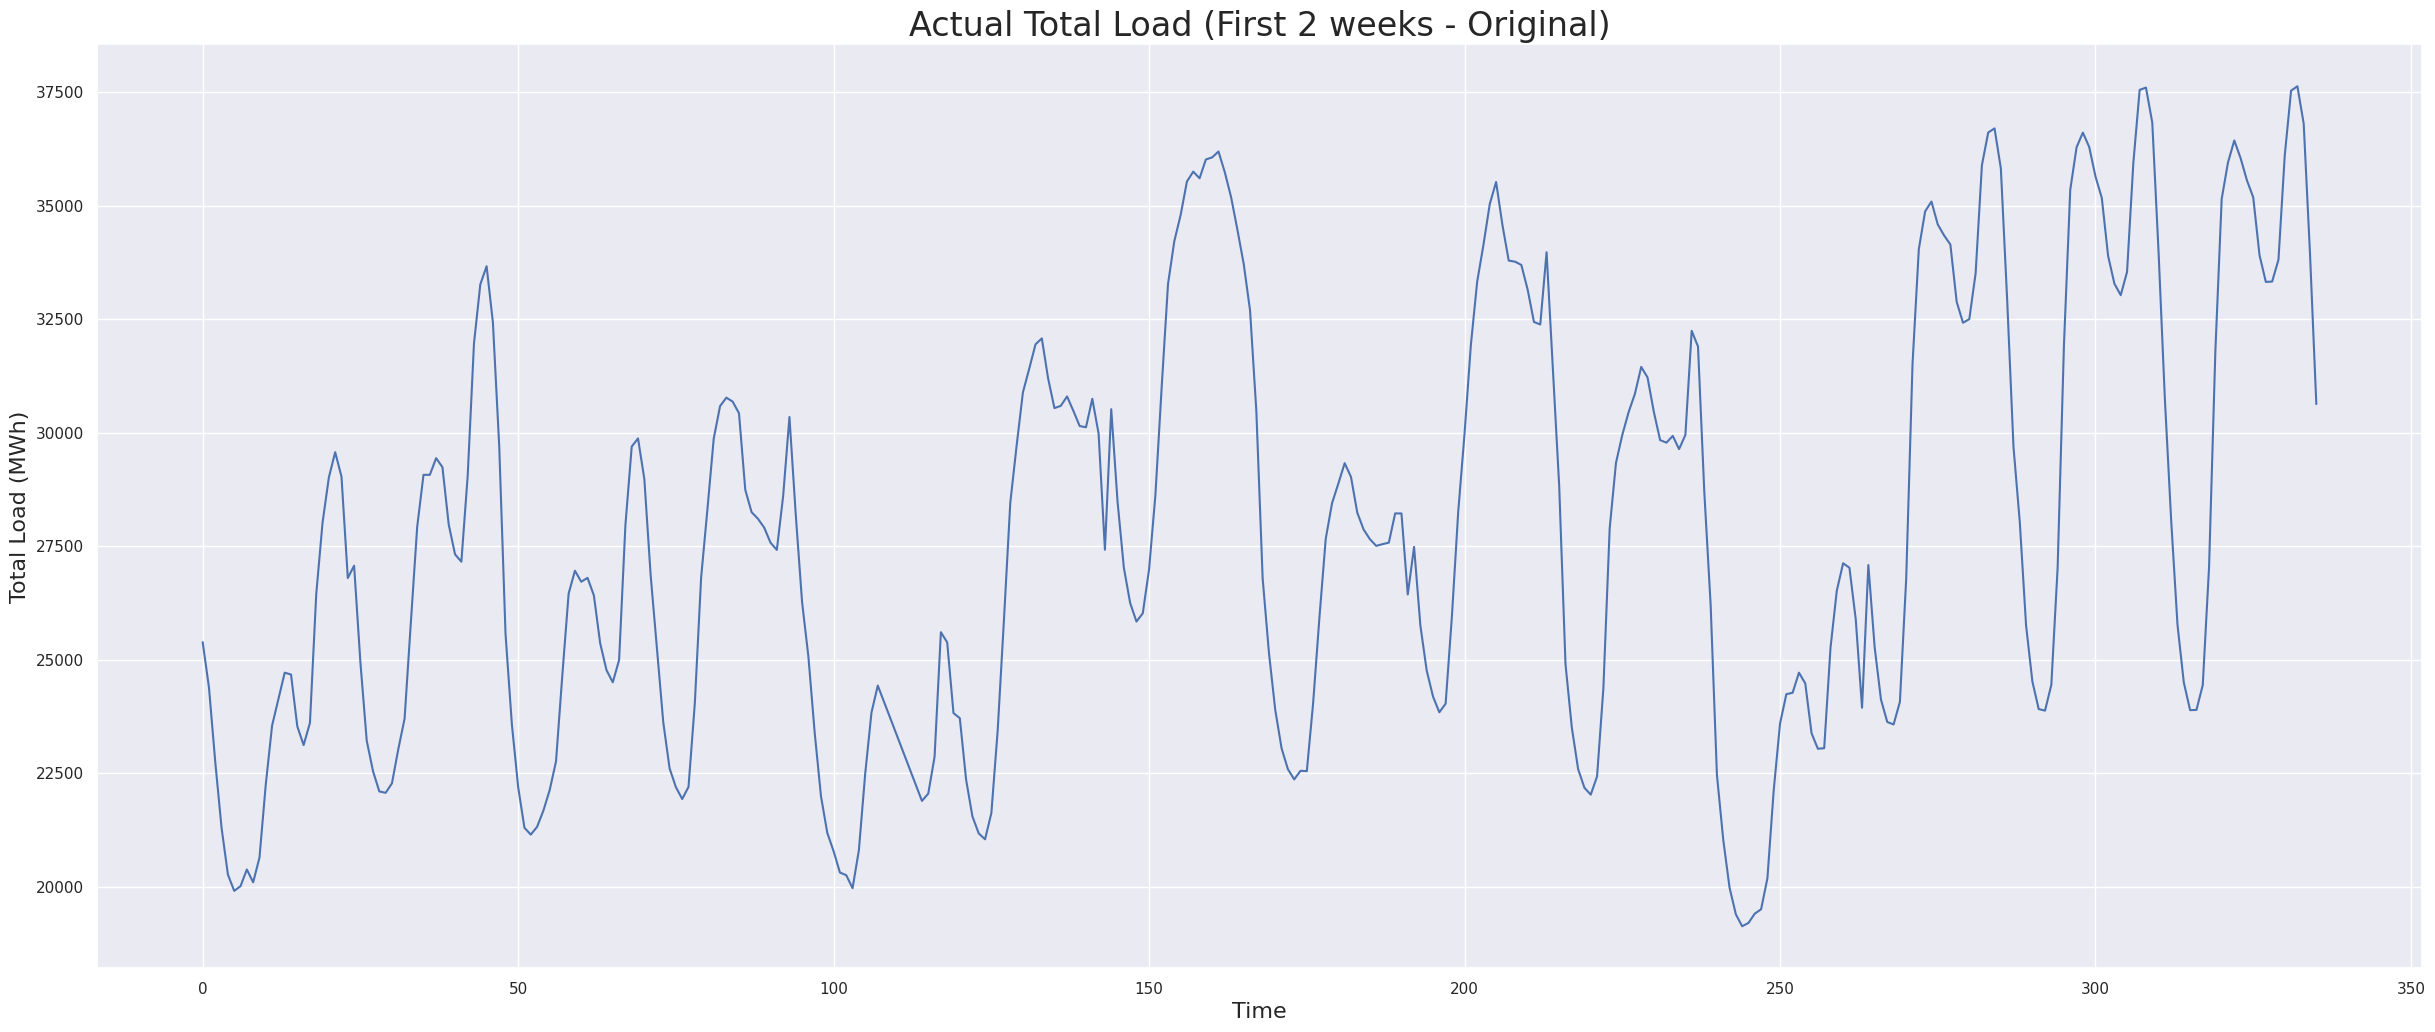

In [14]:
ax = plot_series(df=energy_df, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Original)', end=24*7*2)
plt.show()

Now we filter out all the necessary column as per business requirements.

In [15]:
energy_df=energy_df.drop(columns=['generation fossil coal-derived gas','generation fossil oil shale','generation fossil peat','generation geothermal','generation marine','generation wind offshore'])
energy_df.to_csv('energy_df.csv')

Now lets start the modelling process. We tried multiple models like ARIMA, Auto-ARIMA, SARIMAX, Prophet, XGBoost and RFR. Finally we proceeded with XGBoost & RFR.

In [17]:
# Load the dataset
df = pd.read_csv('energy_df.csv')

# Assume the date column is named 'time', change if different
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df.sort_index(inplace=True)

# Create features: lag features and rolling means
for i in range(1, 25):  # extending lags to 24 hours
    df[f'lag_{i}'] = df['total load actual'].shift(i)
df['rolling_mean_6'] = df['total load actual'].rolling(window=6).mean()
df['rolling_mean_12'] = df['total load actual'].rolling(window=12).mean()

# Drop NaN values that were created by lag features
df = df.dropna()

# Split features and target
X = df.drop('total load actual', axis=1)
y = df['total load actual']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Define the model
model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Setup GridSearchCV
param_grid = {
    'n_estimators': [100, 500], # Reduced from [100, 500, 1000]
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],       # Reduced from [3, 5, 7]
    'subsample': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate accuracy metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


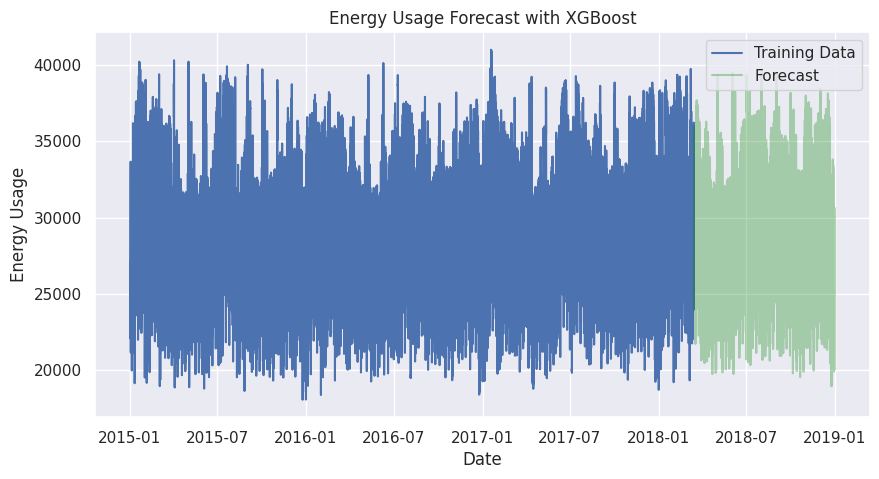

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(y_train.index, y_train, label='Training Data')
#plt.plot(y_test.index, y_test, label='Test Data')
plt.plot(y_test.index, y_pred, label='Forecast', color='green', alpha=0.3)
plt.title('Energy Usage Forecast with XGBoost')
plt.xlabel('Date')
plt.ylabel('Energy Usage')
plt.legend()
plt.show()

In [19]:
# Display the metrics
print("Best model params:", grid_search.best_params_)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R^2 Score:", r2)

Best model params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}
Mean Absolute Error (MAE): 314.9313276456371
Mean Squared Error (MSE): 197356.7335010582
Root Mean Squared Error (RMSE): 444.24850421926936
R^2 Score: 0.9903333440047084


Looking into the R^2 value our model seems to be perfectly fit, but we want to add another additional requirement for our stakeholder in which we want to forecast the maximum energy consumption for each day according to the  'total load actual' column's maximum value for each day. For this we have filtered out data through the 'Excel' itself where we have taken the maximum values of 'total load actual' column for each day for the corresponding 'time' column.

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best model params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}
Mean Absolute Error (MAE): 997.6243557400173
Mean Squared Error (MSE): 1757502.1851082246
Root Mean Squared Error (RMSE): 1325.7081824852046
R^2 Score: 0.8198242626502533


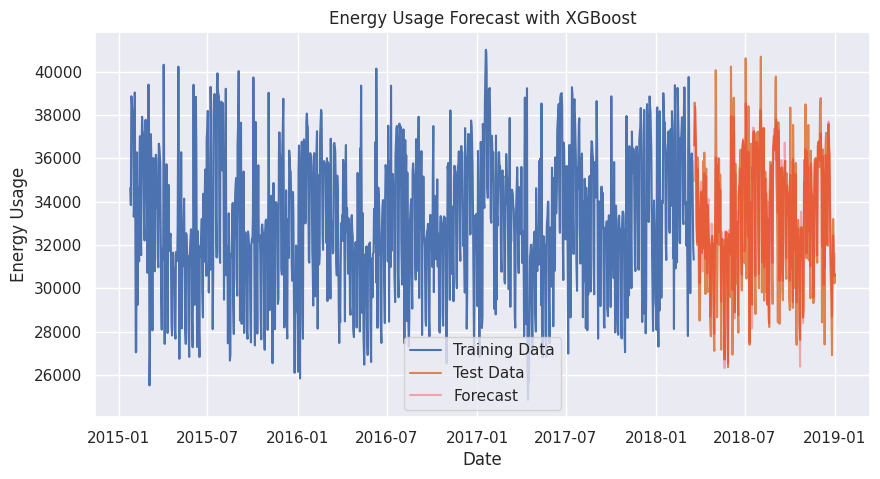

In [22]:
# Load the dataset
df = pd.read_csv("Maximum_Load_Per_Day_with_Timestamps.csv")
df['time'] = pd.to_datetime(df['time'], utc=True)
df.set_index('time', inplace=True)
df.sort_index(inplace=True)

# Create features: lag features and rolling means
for i in range(1, 25):  # extending lags to 24 hours
    df[f'lag_{i}'] = df['total load actual'].shift(i)
df['rolling_mean_6'] = df['total load actual'].rolling(window=6).mean()
df['rolling_mean_12'] = df['total load actual'].rolling(window=12).mean()

# Drop NaN values that were created by lag features
df = df.dropna()

# Split features and target
X = df.drop('total load actual', axis=1)
y = df['total load actual']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Define the model
model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Setup GridSearchCV
param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate accuracy metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display the metrics
print("Best model params:", grid_search.best_params_)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")

# Ploting the results
plt.figure(figsize=(10, 5))
plt.plot(y_train.index, y_train, label='Training Data')
plt.plot(y_test.index, y_test, label='Test Data')
plt.plot(y_test.index, y_pred, label='Forecast', color='red',alpha=0.3)
plt.title('Energy Usage Forecast with XGBoost')
plt.xlabel('Date')
plt.ylabel('Energy Usage')
plt.legend()
plt.show()

The above forecast was for 12 months for each 6 months . To forecast for next 5 years we have modified our parameters below.

/tmp/ipython-input-1441379896.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row = future_df.loc[date].fillna(method='ffill').to_frame().T
/tmp/ipython-input-1441379896.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row = future_df.loc[date].fillna(method='ffill').to_frame().T
/tmp/ipython-input-1441379896.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row = future_df.loc[date].fillna(method='ffill').to_frame().T
/tmp/ipython-input-1441379896.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row = future_df.loc[date].fillna(method='ffill').to_frame().T
/tmp/ipython-input-1441379896.py:29: FutureWarning: Series.filln

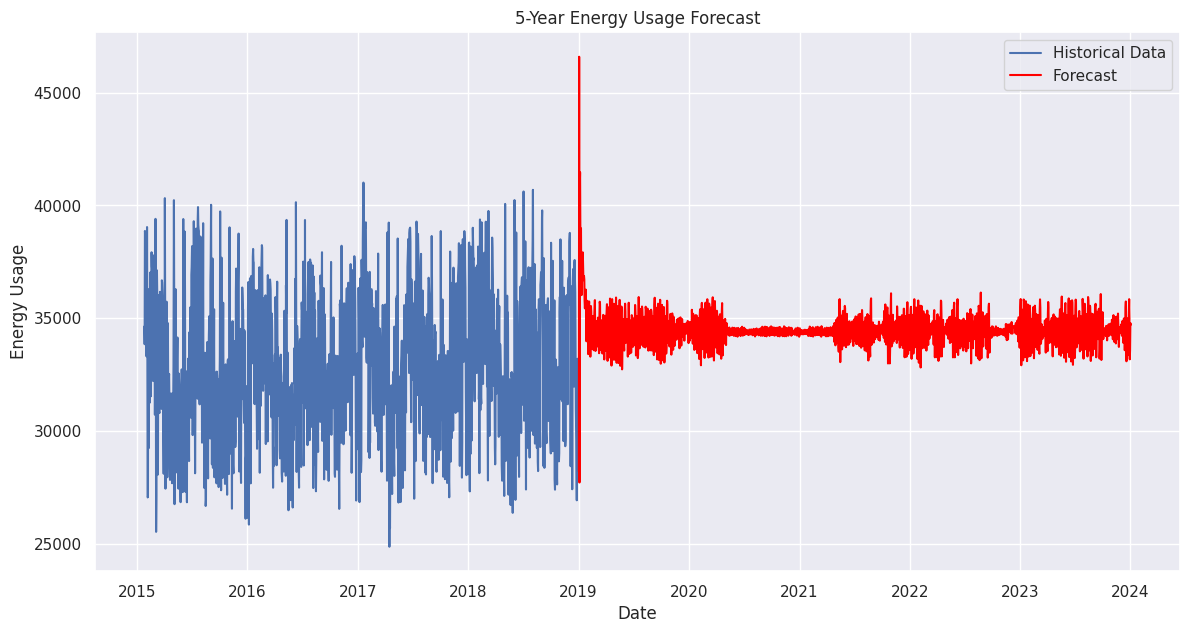

In [23]:
start_date = df.index.max() + timedelta(days=1)
end_date = start_date + pd.DateOffset(years=5)

# Create a date range for the forecast period
future_dates = pd.date_range(start=start_date, end=end_date, freq='D')
# Initialize future DataFrame with necessary columns
future_df = pd.DataFrame(index=future_dates)
for i in range(1, 25):
    future_df[f'lag_{i}'] = np.nan

# Initially populate lag features using the last available values from `df`
last_values = df['total load actual'][-24:].values[::-1]
for i in range(1, 25):
    future_df.at[future_dates[0], f'lag_{i}'] = last_values[i-1]

# Now also calculate the rolling means for the first prediction point
future_df['rolling_mean_6'] = np.nan
future_df['rolling_mean_12'] = np.nan

# Start the recursive prediction and feature updating
predicted_values = []
for date in future_df.index:
    if len(predicted_values) >= 12:
        future_df.at[date, 'rolling_mean_12'] = np.mean(predicted_values[-12:])
    if len(predicted_values) >= 6:
        future_df.at[date, 'rolling_mean_6'] = np.mean(predicted_values[-6:])

    # Prepare the row for prediction, filling forward NaNs
    row = future_df.loc[date].fillna(method='ffill').to_frame().T
    prediction = best_model.predict(row)[0]
    predicted_values.append(prediction)

    # Update the lag features for the next day
    for i in range(1, 25):
        if date + timedelta(days=1) in future_df.index:
            future_df.at[date + timedelta(days=1), f'lag_{i}'] = prediction if i == 1 else future_df.at[date, f'lag_{i-1}']

# Assign predictions back to future DataFrame
future_df['predicted_load'] = predicted_values

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['total load actual'], label='Historical Data')
plt.plot(future_df.index, future_df['predicted_load'], label='Forecast', color='red')
plt.title('5-Year Energy Usage Forecast')
plt.xlabel('Date')
plt.ylabel('Energy Usage')
plt.legend()
plt.show()

Now we will look into RFR model for forecasting energy consumption.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best model parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Mean Absolute Error (MAE): 1516.187476504877
Mean Squared Error (MSE): 3957865.0754526127
Root Mean Squared Error (RMSE): 1989.4383819190311
R^2 Score: 0.5942472991824059


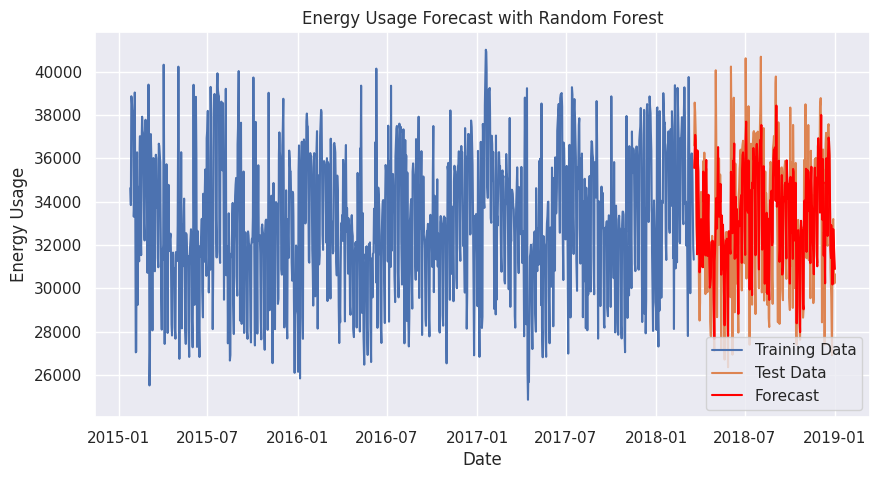

In [26]:
# Load the dataset
df = pd.read_csv("Maximum_Load_Per_Day_with_Timestamps.csv")
df['time'] = pd.to_datetime(df['time'], utc=True)
df.set_index('time', inplace=True)
df.sort_index(inplace=True)

# Create features: lag features and rolling means
for i in range(1, 25):  # extending lags to 24 hours
    df[f'lag_{i}'] = df['total load actual'].shift(i)
df['rolling_mean_6'] = df['total load actual'].rolling(window=6).mean()
df['rolling_mean_12'] = df['total load actual'].rolling(window=12).mean()

# Drop NaN values that were created by lag features
df = df.dropna()

# Split features and target
X = df.drop('total load actual', axis=1)
y = df['total load actual']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Define the model
rfr_model = RandomForestRegressor(random_state=42)

# Setup GridSearchCV for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100],  # Further reduced for faster execution
    'max_depth': [5, 10],      # Further reduced for faster execution
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(rfr_model, param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_rfr_model = grid_search.best_estimator_

# Make predictions
rfr_pred = best_rfr_model.predict(X_test)

# Calculate accuracy metrics
mae = mean_absolute_error(y_test, rfr_pred)
mse = mean_squared_error(y_test, rfr_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, rfr_pred)

# Display the metrics
print("Best model parameters:", grid_search.best_params_)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(y_train.index, y_train, label='Training Data')
plt.plot(y_test.index, y_test, label='Test Data')
plt.plot(y_test.index, rfr_pred, label='Forecast', color='red')
plt.title('Energy Usage Forecast with Random Forest')
plt.xlabel('Date')
plt.ylabel('Energy Usage')
plt.legend()
plt.show()

As you can see from above visualization, RFR for next 12 months the energy forecast for each 6 months will provide moderate fitting. The R^2 value is not as good as comapred to XGBoost. We will still try to see forecasting with RFR for next 5 years as well.

Streaming output truncated to the last 5000 lines.
/tmp/ipython-input-990168367.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row = future_df.loc[date].fillna(method='ffill')  # Forward fill to handle any initial NAs
/tmp/ipython-input-990168367.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  row = future_df.loc[date].fillna(method='ffill')  # Forward fill to handle any initial NAs
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/tmp/ipython-input-990168367.py:28: FutureWarning: Series.fillna with 'method' is deprecated and 

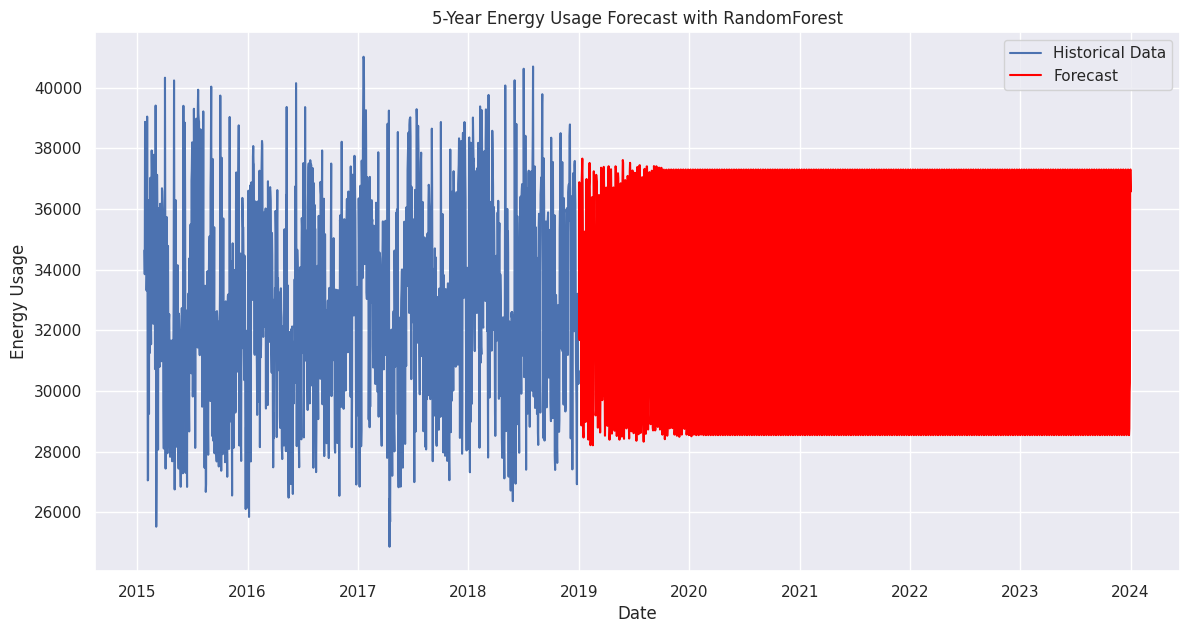

In [27]:
# Assume `best_rfr_model` is the trained RandomForest model and `df` is the DataFrame from your previous setup
# Define the start date for the forecast
start_date = df.index.max() + timedelta(days=1)
end_date = start_date + pd.DateOffset(years=5)

# Create a date range for the forecast period
future_dates = pd.date_range(start=start_date, end=end_date, freq='D')
future_df = pd.DataFrame(index=future_dates)

# Initialize lag and rolling mean features based on the last values from `df`
for i in range(1, 25):
    future_df[f'lag_{i}'] = None
future_df['rolling_mean_6'] = None
future_df['rolling_mean_12'] = None

# Fill initial values for lag features and rolling means
last_actual_loads = df['total load actual'].iloc[-24:].tolist()
for i in range(1, 25):
    future_df.loc[future_dates[0], f'lag_{i}'] = last_actual_loads[-i]  # Reverse order to match lag indexes

future_df.loc[future_dates[0], 'rolling_mean_6'] = np.mean(last_actual_loads[-6:])
future_df.loc[future_dates[0], 'rolling_mean_12'] = np.mean(last_actual_loads[-12:])

# Predict day-by-day, updating features
predicted_loads = []
for date in future_df.index:
    # Prepare data for prediction
    row = future_df.loc[date].fillna(method='ffill')  # Forward fill to handle any initial NAs
    prediction = best_rfr_model.predict([row])[0]
    predicted_loads.append(prediction)

    # Update lag features for the next day
    if date + timedelta(days=1) in future_df.index:
        future_df.loc[date + timedelta(days=1), 'lag_1'] = prediction
        for i in range(2, 25):
            future_df.loc[date + timedelta(days=1), f'lag_{i}'] = future_df.loc[date, f'lag_{i-1}']

# Store the predicted values
future_df['predicted_load'] = predicted_loads

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['total load actual'], label='Historical Data')
plt.plot(future_df.index, future_df['predicted_load'], label='Forecast', color='red')
plt.title('5-Year Energy Usage Forecast with RandomForest')
plt.xlabel('Date')
plt.ylabel('Energy Usage')
plt.legend()
plt.show()

Based on our model comparisons for forcasting, we are choosing XGBoost. Now we will try to find the correlation matrix between different energy sources of generation and 'total load actual' column.

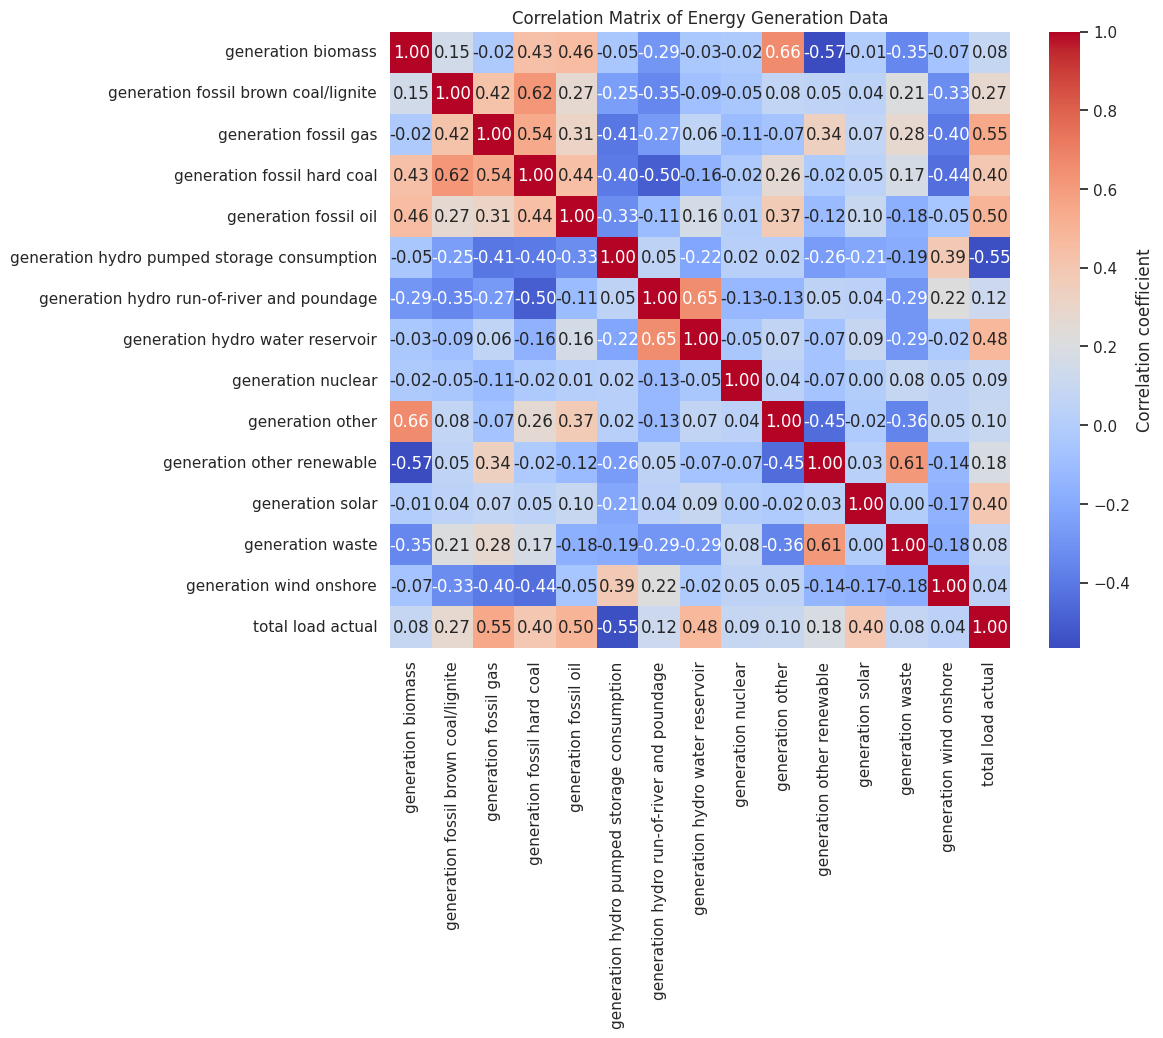

In [28]:
data = pd.read_csv('df_combined.csv')

# Exclude the non-relevant columns
columns_to_exclude = ['time', 'city_name']
data_filtered = data.drop(columns=columns_to_exclude)

# Calculate the correlation matrix
correlation_matrix = data_filtered.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation coefficient'})
plt.title('Correlation Matrix of Energy Generation Data')
plt.show()

In [29]:
correlations = correlation_matrix['total load actual'].drop('total load actual')
# Sort the correlations and get the top 5
top_6_parameters = correlations.abs().sort_values(ascending=False).head(6)

# Print the top 5 correlated parameters
print(top_6_parameters)

generation fossil gas                          0.549228
generation hydro pumped storage consumption    0.547674
generation fossil oil                          0.497627
generation hydro water reservoir               0.479624
generation fossil hard coal                    0.397552
generation solar                               0.395592
Name: total load actual, dtype: float64


/tmp/ipython-input-2537245304.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_3['time'] = pd.to_datetime(data_3['time'])
/tmp/ipython-input-2537245304.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_3['generation hydro pumped storage consumption'] = pd.to_numeric(data_3['generation hydro pumped storage consumption'], errors='coerce')
/tmp/ipython-input-2537245304.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

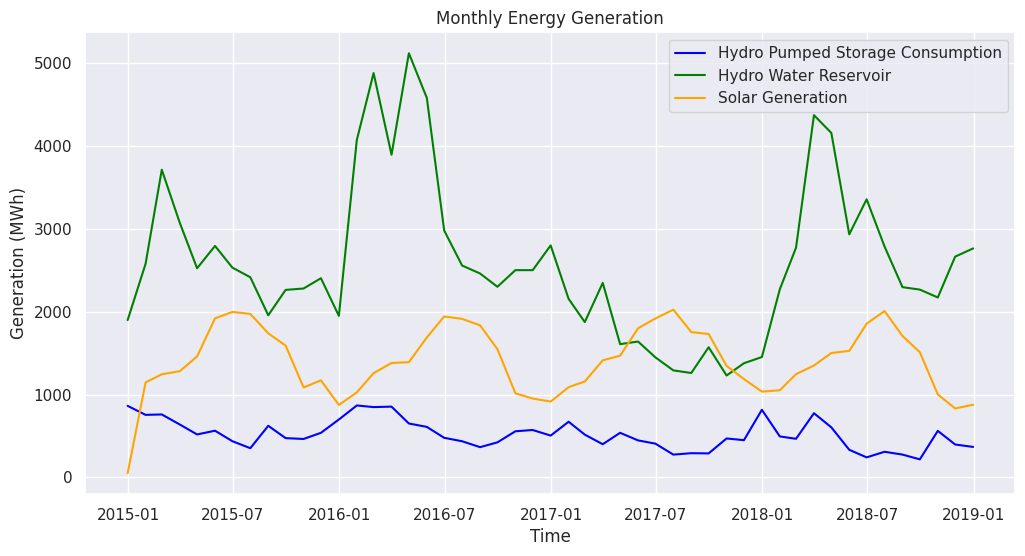

In [30]:
data_2 = pd.read_csv('df_combined.csv')
data_3= data_2[['time','generation hydro pumped storage consumption','generation hydro water reservoir','generation solar']]
#data_3.dtypes
# Ensure the 'time' column is treated as a datetime type
data_3['time'] = pd.to_datetime(data_3['time'])

# # Set 'time' as the index of the dataframe
data_3.set_index('time', inplace=True)

#data_2 .index
# # Convert generation columns to numeric, errors='coerce' will convert non-numeric values to NaN
data_3['generation hydro pumped storage consumption'] = pd.to_numeric(data_3['generation hydro pumped storage consumption'], errors='coerce')
data_3['generation hydro water reservoir'] = pd.to_numeric(data_3['generation hydro water reservoir'], errors='coerce')
data_3['generation solar'] = pd.to_numeric(data_3['generation solar'], errors='coerce')

# Resample data monthly and calculate the mean for each month
monthly_data = data_3.resample('M').mean()

# Plot the resampled data
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['generation hydro pumped storage consumption'], label='Hydro Pumped Storage Consumption', color='blue')
plt.plot(monthly_data['generation hydro water reservoir'], label='Hydro Water Reservoir', color='green')
plt.plot(monthly_data['generation solar'], label='Solar Generation', color='orange')

# Adding title and labels
plt.title('Monthly Energy Generation')
plt.xlabel('Time')
plt.ylabel('Generation (MWh)')
plt.legend()

# Show the plot
plt.show()
# data_2.dtypes

As above visualisation highlights the energy generation for the sources mentioned in labels in Valencia,for our stakeholders we suggest to look into the "Hydro Pumped Storage", "Hydro Water Reservoir" and "Solar Generation" renewable energy sources for investment in sustainable energy generation. If provided with similar data from utility companies and energy generation plants, our model could forecast the energy consumption and we could also suggest for different renewable source based on data analysis of provided data. For efficient forecasting we would ask stakeholders to provide additional following data:
1)Area Population Data.
2)Energy consumption history for appliances used in the region.
3)Utility Bills Pricing Data
4)Additional Data Points
  